### **Imbalanced clustering metrics for benchmarking, analysis, and comparison studies** 

`imbalanced-clustering` is a python library that has repurposed popular clustering indices such as the Adjusted Rand Index (ARI) and Adjusted Mutual Information (AMI) to account for class imbalance. Although the original intended use of these metrics was to compare clustering results from different techniques, they have recently been applied frequently in cases where ground-truth labels exist and the result of a clustering technique is compared to  these values. An example of this is in single-cell sequencing benchmarking studies, where ground-truth celltype labels are compared to clustering results after a meaningful transformation of the latent space, such as the integration of two or more datasets. 

Although these metrics are meaningful in these settings, they often overemphasize the importance of larger classes in the data. In single-cell datasets, it's common that some celltypes exist in greater proportions than others in a given tissue sample, and they will thus be overrepresented in the sequencing data (e.g. alpha and beta cells from pancreatic islet samples). Because of this overrepresentation, the larger classes will have a greater influence on the results of these common clustering metrics. This may hide important information about smaller classes/celltypes, and potential erasure of their heterogeneity in a clustering setting. This problem is akin to the imbalanced learning problem in classical machine learning literature, where metrics such as accuracy and precision/recall can fail to capture the effects of a classifier on smaller/minority classes. 

Given this limitation, the `imbalanced-clustering` python library balances popular clustering metrics, such that the information from each of the classes from the ground-truth data, regardless of their representation in the data, will be weighted equally. 

The following demo notebook is divided up into two parts:

**A)**: First we begin by examining how this weighing is done to account for ground-truth class imbalance by specifically considering the Adjusted Rand Index (ARI), as the other metrics undergo the exact same changes.

**B)**: The feasibility of these metrics, as well as their concordance with the base imbalanced metrics is determined. To begin, sanity checks and control experiments are done to determine if the same results hold for both the base and modified balanced metrics. Then, different class/clustering scenarios are explored that emphasize the utility of the balanced metrics. 

### Part A) Analysis of reweighting of the Adjusted Rand Index  

### Part B) Computational analysis of balanced metrics 

In this part of the demo, we'll look at some of the properties of these balanced metrics, perform some sanity checks to ensure they are working as intended, and demonstrate important use cases and results. 

For **Part B-1)**, we'll start by looking at some baselines to ensure that the balanced metrics return similar results as the baseline metrics in edge cases and randomized data. There are two properties we want to ensure that exist, namely the expectation - where a random clustering results in a similar value for both, and normalization, where both the balanced and baseline metrics are bounded in the same way. We've ensured that these properties hold theoretically, and we'll demonstrate that they do computationally. 

Let's begin by loading the appropriate functions and libraries.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, \
    homogeneity_score, completeness_score, v_measure_score
from sklearn.cluster import KMeans

from imbalanced_clustering import balanced_adjusted_rand_index, \
    balanced_adjusted_mutual_info, balanced_completeness, \
    balanced_homogeneity, balanced_v_measure 

We can begin testing random clustering by sampling data from a uniform distribution for 3 classes, and then performing k-means clustering (k = 3) on them. This should result in clusters that have the same number of classes in each of them. Let's see how the metrics behave when the classes are balanced (same number in each) in this respect. This will be **Sanity check #1**:

Class scatterplot:


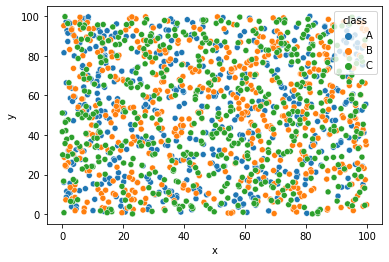

K-means classification scatterplot:


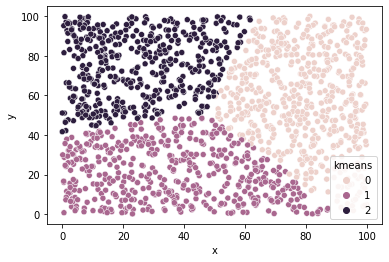

ARI imbalanced: 0.0013 ARI balanced: 0.0013
AMI imbalanced: 0.0011 AMI balanced: 0.0011
Homogeneity imbalanced: 0.0023 Homogeneity balanced: 0.0023
Completeness imbalanced: 0.0023 Completeness balanced : 0.0023
V-measure imbalanced: 0.0023 V-measure balanced: 0.0023


<Figure size 432x288 with 0 Axes>

In [17]:
# Set a seed for reproducibility 
np.random.seed(42)

# Sample three classes from a uniform distribution
c_1 = np.random.uniform(0, 100, (500, 2))
c_2 = np.random.uniform(0, 100, (500, 2))
c_3 = np.random.uniform(0, 100, (500, 2))

# Plot the given results for each class using seaborn
# Ensure to clear plot afterwards 
cluster_df = pd.DataFrame({
    "x" : np.concatenate((c_1[:, 0], c_2[:, 0], c_3[:, 0])),
    "y" : np.concatenate((c_1[:, 1], c_2[:, 1], c_3[:, 1])),
    "class": np.concatenate(
        (
            np.repeat("A", len(c_1)),
            np.repeat("B", len(c_2)),
            np.repeat("C", len(c_3))
        )
    )
})
print("Class scatterplot:")
sns.scatterplot(
    x = "x",
    y = "y",
    hue = "class",
    data = cluster_df
)
plt.show()
plt.clf()

# Perform k-means clustering with k = 3, and plot the results  
cluster_arr = np.array(cluster_df.iloc[:, 0:2])
kmeans_res = KMeans(n_clusters = 3).fit_predict(X = cluster_arr)

cluster_df["kmeans"] = kmeans_res # Add k-means to cluster df 
print("K-means classification scatterplot:")
sns.scatterplot(
    x = "x",
    y = "y",
    hue = "kmeans",
    data = cluster_df
)
plt.show()
plt.clf()

# Determine the values for imbalanced and balanced ARI, AMI, Homogeneity, 
# Completeness, and V-measure and compare - define a function to do this
def return_metrics(class_arr, cluster_arr):
    # Determine the imbalanced (base) metric scores 
    ari_imbalanced = adjusted_rand_score(class_arr, cluster_arr)
    ami_imbalanced = adjusted_mutual_info_score(class_arr, cluster_arr)
    homog_imbalanced = homogeneity_score(class_arr, cluster_arr)
    complete_imbalanced = completeness_score(class_arr, cluster_arr)
    v_measure_imbalanced = v_measure_score(class_arr, cluster_arr)

    # Determine the balanced metrics from `imbalanced-clustering`
    ari_balanced = balanced_adjusted_rand_index(class_arr, cluster_arr)
    ami_balanced = balanced_adjusted_mutual_info(class_arr, cluster_arr)
    homog_balanced = balanced_homogeneity(class_arr, cluster_arr)
    complete_balanced = balanced_completeness(class_arr, cluster_arr)
    v_measure_balanced = balanced_v_measure(class_arr, cluster_arr)
    
    # Return paired balanced imbalance scores
    return (ari_imbalanced, ari_balanced), (ami_imbalanced, ami_balanced), \
        (homog_imbalanced, homog_balanced), (complete_imbalanced, complete_balanced), \
        (v_measure_imbalanced, v_measure_balanced)

# Return and print balanced and imbalanced comparisons 
aris, amis, homogs, completes, v_measures = return_metrics(
    class_arr = cluster_df["class"], cluster_arr = cluster_df["kmeans"]
)
print(
    "ARI imbalanced: " + str(round(aris[0], 4)) + " " + 
    "ARI balanced: " + str(round(aris[1], 4))
)
print(
    "AMI imbalanced: " + str(round(amis[0], 4)) + " " +
    "AMI balanced: " + str(round(amis[1], 4))
)
print(
    "Homogeneity imbalanced: " + str(round(homogs[0], 4)) + " " +
    "Homogeneity balanced: " + str(round(homogs[1], 4))
)
print(
    "Completeness imbalanced: " + str(round(completes[0], 4)) + " " +
    "Completeness balanced : " + str(round(completes[1], 4))
)
print(
    "V-measure imbalanced: " + str(round(v_measures[0], 4)) + " " +
    "V-measure balanced: " + str(round(v_measures[1], 4))
)



As we can see, the results for the balanced and imbalanced metrics are the exact same, which is what we expect. Further, the results are **close to zero**, which is also expected behavior of these metrics under conditions that the clustering is completely random (which in this test, it was). 

Let's perform **Sanity Check #2**, where we do this for cases where the classes are imbalanced.  

Class scatterplot:


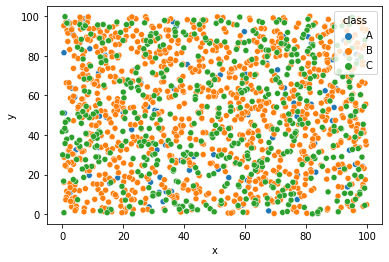

K-means classification scatterplot:


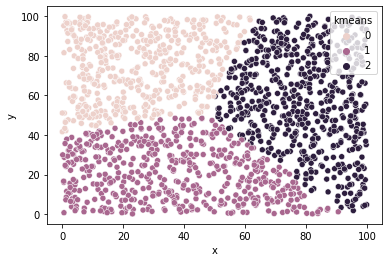

ARI imbalanced: 0.001 ARI balanced: 0.0041
AMI imbalanced: 0.0007 AMI balanced: 0.0004
Homogeneity imbalanced: 0.0023 Homogeneity balanced: 0.002
Completeness imbalanced: 0.0017 Completeness balanced : 0.0015
V-measure imbalanced: 0.002 V-measure balanced: 0.0018


<Figure size 432x288 with 0 Axes>

In [18]:
# Set a seed for reproducibility 
np.random.seed(42)

# Sample three classes from a uniform distribution - this time with 
# mixed class sizes (imbalance across the board)
c_1 = np.random.uniform(0, 100, (100, 2))
c_2 = np.random.uniform(0, 100, (1000, 2))
c_3 = np.random.uniform(0, 100, (500, 2))

# Plot the given results for each class using seaborn
# Ensure to clear plot afterwards 
cluster_df = pd.DataFrame({
    "x" : np.concatenate((c_1[:, 0], c_2[:, 0], c_3[:, 0])),
    "y" : np.concatenate((c_1[:, 1], c_2[:, 1], c_3[:, 1])),
    "class": np.concatenate(
        (
            np.repeat("A", len(c_1)),
            np.repeat("B", len(c_2)),
            np.repeat("C", len(c_3))
        )
    )
})
print("Class scatterplot:")
sns.scatterplot(
    x = "x",
    y = "y",
    hue = "class",
    data = cluster_df
)
plt.show()
plt.clf()

# Perform k-means clustering with k = 3, and plot the results  
cluster_arr = np.array(cluster_df.iloc[:, 0:2])
kmeans_res = KMeans(n_clusters = 3).fit_predict(X = cluster_arr)

cluster_df["kmeans"] = kmeans_res # Add k-means to cluster df 
print("K-means classification scatterplot:")
sns.scatterplot(
    x = "x",
    y = "y",
    hue = "kmeans",
    data = cluster_df
)
plt.show()
plt.clf()

# Determine the values for imbalanced and balanced ARI, AMI, Homogeneity, 
# Completeness, and V-measure and compare - define a function to do this
def return_metrics(class_arr, cluster_arr):
    # Determine the imbalanced (base) metric scores 
    ari_imbalanced = adjusted_rand_score(class_arr, cluster_arr)
    ami_imbalanced = adjusted_mutual_info_score(class_arr, cluster_arr)
    homog_imbalanced = homogeneity_score(class_arr, cluster_arr)
    complete_imbalanced = completeness_score(class_arr, cluster_arr)
    v_measure_imbalanced = v_measure_score(class_arr, cluster_arr)

    # Determine the balanced metrics from `imbalanced-clustering`
    ari_balanced = balanced_adjusted_rand_index(class_arr, cluster_arr)
    ami_balanced = balanced_adjusted_mutual_info(class_arr, cluster_arr)
    homog_balanced = balanced_homogeneity(class_arr, cluster_arr)
    complete_balanced = balanced_completeness(class_arr, cluster_arr)
    v_measure_balanced = balanced_v_measure(class_arr, cluster_arr)
    
    # Return paired balanced imbalance scores
    return (ari_imbalanced, ari_balanced), (ami_imbalanced, ami_balanced), \
        (homog_imbalanced, homog_balanced), (complete_imbalanced, complete_balanced), \
        (v_measure_imbalanced, v_measure_balanced)

# Return and print balanced and imbalanced comparisons 
aris, amis, homogs, completes, v_measures = return_metrics(
    class_arr = cluster_df["class"], cluster_arr = cluster_df["kmeans"]
)
print(
    "ARI imbalanced: " + str(round(aris[0], 4)) + " " + 
    "ARI balanced: " + str(round(aris[1], 4))
)
print(
    "AMI imbalanced: " + str(round(amis[0], 4)) + " " +
    "AMI balanced: " + str(round(amis[1], 4))
)
print(
    "Homogeneity imbalanced: " + str(round(homogs[0], 4)) + " " +
    "Homogeneity balanced: " + str(round(homogs[1], 4))
)
print(
    "Completeness imbalanced: " + str(round(completes[0], 4)) + " " +
    "Completeness balanced : " + str(round(completes[1], 4))
)
print(
    "V-measure imbalanced: " + str(round(v_measures[0], 4)) + " " +
    "V-measure balanced: " + str(round(v_measures[1], 4))
)



This time, we do see some slight differences between the imbalanced and balanced metrics - **this is expected behavior**. This is happening because we had a class imbalance to start off with, and the balanced metrics will take this into account. However, because the clustering is still random, the balanced metrics still have a result **close to zero**. This example indicates that the **expectation property** holds for the balanced metrics.  